In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

df = pd.read_csv("../materials.csv")

selected_features = [
    "band_gap",
    "is_metal",
    "formation_energy_per_atom",
    "efermi",
    "ordering",
    "max_atomic_numbers",
    "min_atomic_numbers",
    "density",
    "total_magnetization",
    "max_distance_matrix",
    "alpha_parameters",
    'num_magnetic_sites',
    'energy_above_hull',
    'mean_atomic_numbers',
    "total_magnetization_normalized_vol",
    "std_atomic_numbers",
    "a_parameters",
    "std_distance_matrix",
    "gamma_parameters",
    "beta_parameters"
]

df = df[selected_features]

In [2]:
df.dropna(inplace=True)

In [3]:
label_encoder = LabelEncoder()

df["ordering"] = label_encoder.fit_transform(df["ordering"])
df["is_metal"] = label_encoder.fit_transform(df["is_metal"])

In [4]:
X = df.drop(columns=["band_gap"])
y = df["band_gap"]

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [7]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 50, 100, 200, 400],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

search_space = {
    'n_estimators': (100, 500),
    'max_depth': (10, 400),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

rf = RandomForestRegressor(random_state=42)

# search = GridSearchCV(estimator=rf, param_grid=param_dist, cv=3, n_jobs=-1, verbose=2)
# search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=5, cv=3, n_jobs=-1, verbose=2, random_state=42)
search = BayesSearchCV(estimator=rf, search_spaces=search_space, n_iter=1, cv=3, n_jobs=-1, verbose=2, random_state=42)

search.fit(X_train, y_train)

best_params = search.best_params_
print(f"Best parameters: {best_params}")

best_model = search.best_estimator_
best_model.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END max_depth=170, min_samples_leaf=3, min_samples_split=9, n_estimators=226; total time=  44.6s
[CV] END max_depth=170, min_samples_leaf=3, min_samples_split=9, n_estimators=226; total time=  47.6s
[CV] END max_depth=170, min_samples_leaf=3, min_samples_split=9, n_estimators=226; total time=  49.3s
Best parameters: OrderedDict([('max_depth', 170), ('min_samples_leaf', 3), ('min_samples_split', 9), ('n_estimators', 226)])


RandomForestRegressor(max_depth=170, min_samples_leaf=3, min_samples_split=9,
                      n_estimators=226, random_state=42)

In [8]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Mean Squared Error: 0.17256643279265832
Mean Absolute Error: 0.18433821621080002
R² Score: 0.9042383484752078


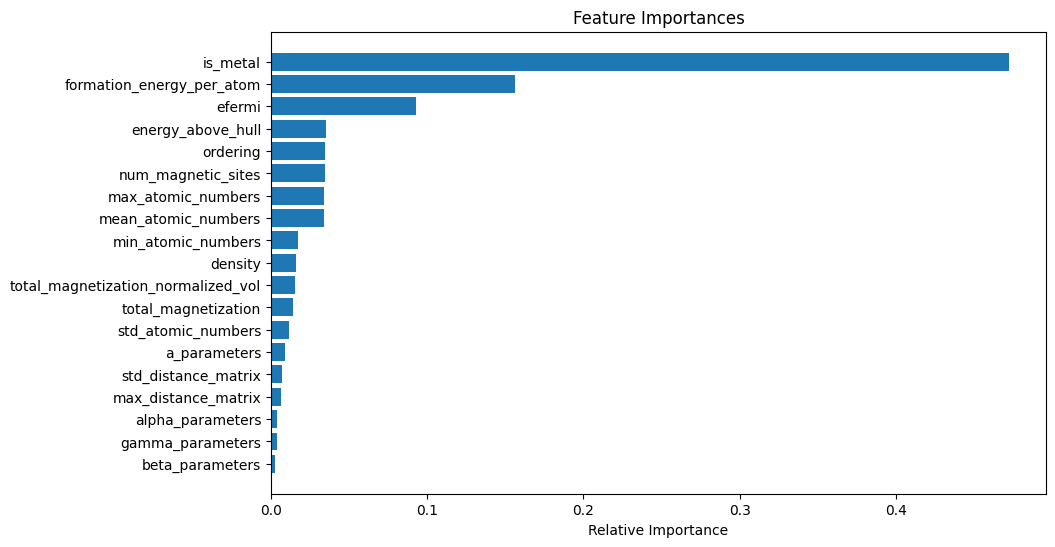

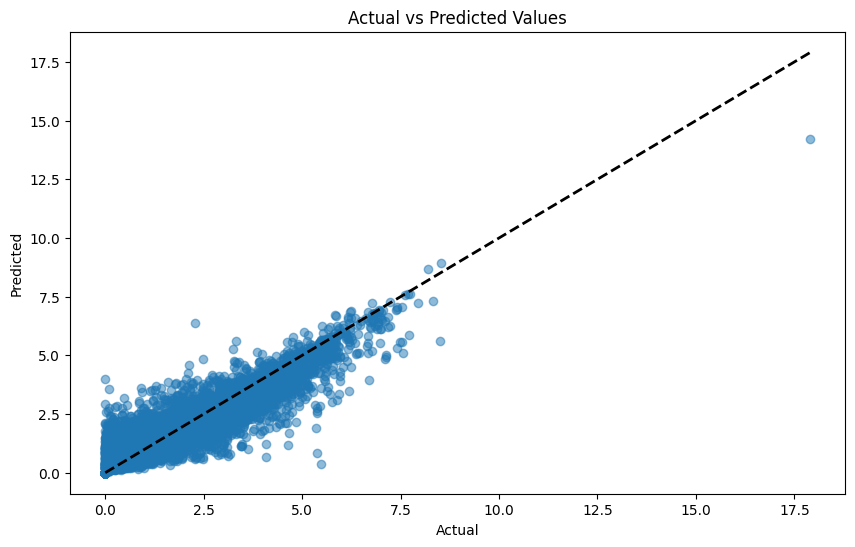

In [9]:
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values")
plt.show()